# Load Data and Word-Embedding Models

In [1]:
import os
import re
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('NER_train.json', 'r'))
val_data = json.load(open('NER_val.json', 'r'))
test_data = json.load(open('NER_test.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# LSTM Implementation

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.lstm = nn.LSTM(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize cell state
        out, (hn, cn) = self.lstm(x, (h0, c0))  # Forward propagate LSTM
        out = self.fc(out)
        return out

# Training and Validation Code

In [4]:
def clean_word(word):
    import string
    clean_word = word.translate(str.maketrans('', '', string.punctuation))
    clean_word = clean_word.strip()
    if not clean_word:
        return ' ' * len(word)
    else:
        return clean_word
    
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            #  Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"]
                pattern = r'[ ]+'
                text = re.split(pattern, text)
                labels = data["labels"]
                #  Convert text to embeddings
                embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Fine-Tuning on Validation Data

In [5]:
def fine_tune(model, embedding_model, val_data,  criterion, optimizer, device='cuda', epochs=3):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    model = model.to(device)
    model.train()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        tuning_loss = 0
        actual = []
        predicted = []
        for _, data in val_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            actual.extend(targets.tolist())     
            tuning_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        tuning_loss = tuning_loss / len(val_data)
        accuracy = accuracy_score(actual, predicted)
        f1 = f1_score(actual, predicted, average="macro")
        print(f"FineTuning: Loss: {tuning_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        

# Testing Code

In [6]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    
    if show_labelwise:
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(test_actual[i])
            labelwise_predictions[test_actual[i]]["predicted"].append(test_predicted[i])
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            import matplotlib.pyplot as plt
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [7]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [8]:
input_size = 300  # Embedding size
hidden_size = 128  # 128 Hidden size of the RNN
output_size = 27   # BIO encoding

# For Word2Vec Embeddings

In [9]:
lstm_word2vec_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_word2vec_model.parameters(), lr=0.001)
# optimizer = optim.SGD(lstm_word2vec_model.parameters(), lr=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [10]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            lstm_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.4086, Accuracy: 0.8992, F1: 0.3524
Validation: Loss: 0.2902, Accuracy: 0.9242, F1: 0.4436
Epoch 2/10
Training: Loss: 0.2606, Accuracy: 0.9284, F1: 0.5068
Validation: Loss: 0.2561, Accuracy: 0.9327, F1: 0.5504
Epoch 3/10
Training: Loss: 0.2175, Accuracy: 0.9381, F1: 0.6047
Validation: Loss: 0.2435, Accuracy: 0.9367, F1: 0.5966
Epoch 4/10
Training: Loss: 0.1859, Accuracy: 0.9454, F1: 0.6646
Validation: Loss: 0.2429, Accuracy: 0.9373, F1: 0.6115
Epoch 5/10
Training: Loss: 0.1585, Accuracy: 0.9520, F1: 0.7091
Validation: Loss: 0.2530, Accuracy: 0.9370, F1: 0.6087
Epoch 6/10
Training: Loss: 0.1363, Accuracy: 0.9579, F1: 0.7487
Validation: Loss: 0.2622, Accuracy: 0.9373, F1: 0.6252
Epoch 7/10
Training: Loss: 0.1166, Accuracy: 0.9634, F1: 0.7846
Validation: Loss: 0.2748, Accuracy: 0.9351, F1: 0.6143
Epoch 8/10
Training: Loss: 0.1004, Accuracy: 0.9682, F1: 0.8183
Validation: Loss: 0.2948, Accuracy: 0.9332, F1: 0.6025
Epoch 9/10
Training: Loss: 0.0867, Accuracy: 0.9

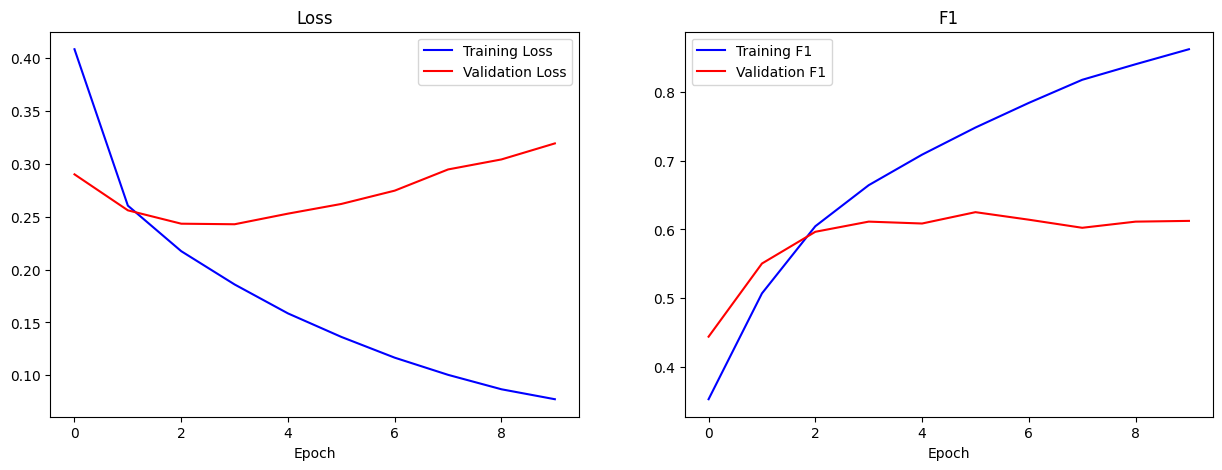

In [11]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [12]:
# fine_tune(lstm_word2vec_model, word2vec, val_data, criterion, optimizer, device='cuda', epochs=2)

In [14]:
lstm_word2vec_model = lstm_word2vec_model.to('cpu')
torch.save(lstm_word2vec_model, "t1_model2_word2vec.pt")

In [15]:
test_accuracy, test_f1 = test("t1_model2_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.03967768579871882, 1: 0.0520393811533052, 2: 0.08118081180811808, 3: 0.025773195876288662, 4: 0.038368411249767184, 5: 0.05250596658711218, 6: 0.06824324324324325, 7: 0.1445578231292517, 8: 0.07582676075826761, 9: 0.2329192546583851, 10: 0.22755610972568577, 11: 0.08441558441558442, 12: 0.09753298909925416, 13: 0.1111111111111111, 14: 0.05257393209200438, 15: 0.040313012034578224, 16: 0.2966666666666667, 17: 0.2380952380952381, 18: 0.1411764705882353, 19: 0.18965517241379312, 20: 0.0736111111111111, 21: 0.14285714285714288, 22: 0.07272727272727272, 23: 0.1886010362694301, 24: 0.10909090909090909, 25: 0.24242424242424243, 26: 0.14444444444444446}
Labelwise Accuracy Scores:
{0: 0.9840131099781501, 1: 0.30578512396694213, 2: 0.5755813953488372, 3: 0.22012578616352202, 4: 0.33225806451612905, 5: 0.5181159420289855, 6: 0.517948717948718, 7: 0.7657657657657657, 8: 0.7154046997389034, 9: 0.872093023255814, 10: 0.8352402745995423, 11: 0.7303370786516854, 12: 0.782208

# For GloVe Embeddings

In [16]:
input_size, hidden_size, output_size = 300, 128, 27

lstm_glove_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(lstm_glove_model.parameters(), lr=0.001)
optimizer = optim.SGD(lstm_glove_model.parameters(), lr=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [17]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            lstm_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10


Training: Loss: 0.5504, Accuracy: 0.8662, F1: 0.1584
Validation: Loss: 0.4556, Accuracy: 0.8830, F1: 0.2512
Epoch 2/10
Training: Loss: 0.4299, Accuracy: 0.8871, F1: 0.2767
Validation: Loss: 0.4161, Accuracy: 0.8924, F1: 0.3359
Epoch 3/10
Training: Loss: 0.3955, Accuracy: 0.8954, F1: 0.3511
Validation: Loss: 0.3987, Accuracy: 0.8956, F1: 0.3749
Epoch 4/10
Training: Loss: 0.3749, Accuracy: 0.8997, F1: 0.3878
Validation: Loss: 0.3904, Accuracy: 0.8978, F1: 0.3998
Epoch 5/10
Training: Loss: 0.3604, Accuracy: 0.9032, F1: 0.4093
Validation: Loss: 0.3866, Accuracy: 0.8995, F1: 0.4070
Epoch 6/10
Training: Loss: 0.3490, Accuracy: 0.9057, F1: 0.4269
Validation: Loss: 0.3839, Accuracy: 0.8991, F1: 0.4087
Epoch 7/10
Training: Loss: 0.3376, Accuracy: 0.9085, F1: 0.4423
Validation: Loss: 0.3833, Accuracy: 0.8994, F1: 0.4119
Epoch 8/10
Training: Loss: 0.3275, Accuracy: 0.9110, F1: 0.4587
Validation: Loss: 0.3836, Accuracy: 0.9004, F1: 0.4211
Epoch 9/10
Training: Loss: 0.3179, Accuracy: 0.9133, F1: 0.

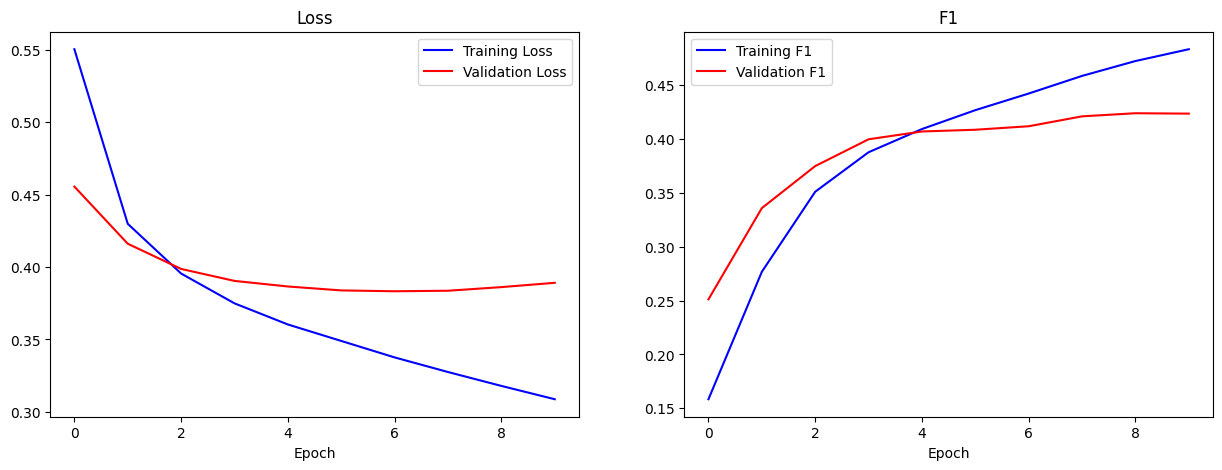

In [18]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [19]:
# fine_tune(lstm_glove_model, glove, val_data, criterion, optimizer, device='cuda', epochs=2)

In [21]:
lstm_glove_model = lstm_glove_model.to('cpu')
torch.save(lstm_glove_model, "t1_model2_glove.pt")

In [22]:
test_accuracy, test_f1 = test("t1_model2_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.036431827574933226, 1: 0.030565461029037184, 2: 0.053422857976937674, 3: 0.0008928571428571429, 4: 0.02511415525114155, 5: 0.02557636887608069, 6: 0.04314504683508374, 7: 0.08207070707070707, 8: 0.06754658385093167, 9: 0.08204292311871773, 10: 0.07877947295423024, 11: 0.038616251005631534, 12: 0.05821689953426481, 13: 0.0404040404040404, 14: 0.05725806451612904, 15: 0.05433238636363636, 16: 0.1310104529616725, 17: 0.0909090909090909, 18: 0.08571428571428572, 19: 0.11428571428571428, 20: 0.032679738562091505, 21: 0.0, 22: 0.0909090909090909, 23: 0.3087719298245614, 24: 0.0, 25: 0.0, 26: 0.015}
Labelwise Accuracy Scores:
{0: 0.9678441369264384, 1: 0.24793388429752067, 2: 0.5319767441860465, 3: 0.006289308176100629, 4: 0.1774193548387097, 5: 0.2572463768115942, 6: 0.38974358974358975, 7: 0.5855855855855856, 8: 0.6814621409921671, 9: 0.5852713178294574, 10: 0.6498855835240275, 11: 0.2696629213483146, 12: 0.5368098159509203, 13: 0.13793103448275862, 14: 0.40112994

# For FastText Embeddings

In [23]:
input_size, hidden_size, output_size = 300, 128, 27
lstm_fasttext_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_fasttext_model.parameters(), lr=0.001)
optimizer = optim.SGD(lstm_fasttext_model.parameters(), lr=0.1, momentum=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [24]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        lstm_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.6008, Accuracy: 0.8601, F1: 0.1108
Validation: Loss: 0.4450, Accuracy: 0.8893, F1: 0.2424
Epoch 2/10
Training: Loss: 0.3914, Accuracy: 0.8969, F1: 0.3093
Validation: Loss: 0.3497, Accuracy: 0.9098, F1: 0.3652
Epoch 3/10
Training: Loss: 0.3240, Accuracy: 0.9122, F1: 0.3851
Validation: Loss: 0.3114, Accuracy: 0.9171, F1: 0.3987
Epoch 4/10
Training: Loss: 0.2912, Accuracy: 0.9195, F1: 0.4226
Validation: Loss: 0.2778, Accuracy: 0.9247, F1: 0.4281
Epoch 5/10
Training: Loss: 0.2721, Accuracy: 0.9240, F1: 0.4476
Validation: Loss: 0.2651, Accuracy: 0.9264, F1: 0.4463
Epoch 6/10
Training: Loss: 0.2550, Accuracy: 0.9282, F1: 0.4702
Validation: Loss: 0.2553, Accuracy: 0.9292, F1: 0.4694
Epoch 7/10
Training: Loss: 0.2428, Accuracy: 0.9306, F1: 0.4899
Validation: Loss: 0.2490, Accuracy: 0.9301, F1: 0.4805
Epoch 8/10
Training: Loss: 0.2341, Accuracy: 0.9324, F1: 0.5138
Validation: Loss: 0.2451, Accuracy: 0.9316, F1: 0.5006
Epoch 9/10
Training: Loss: 0.2235, Accuracy: 0.9

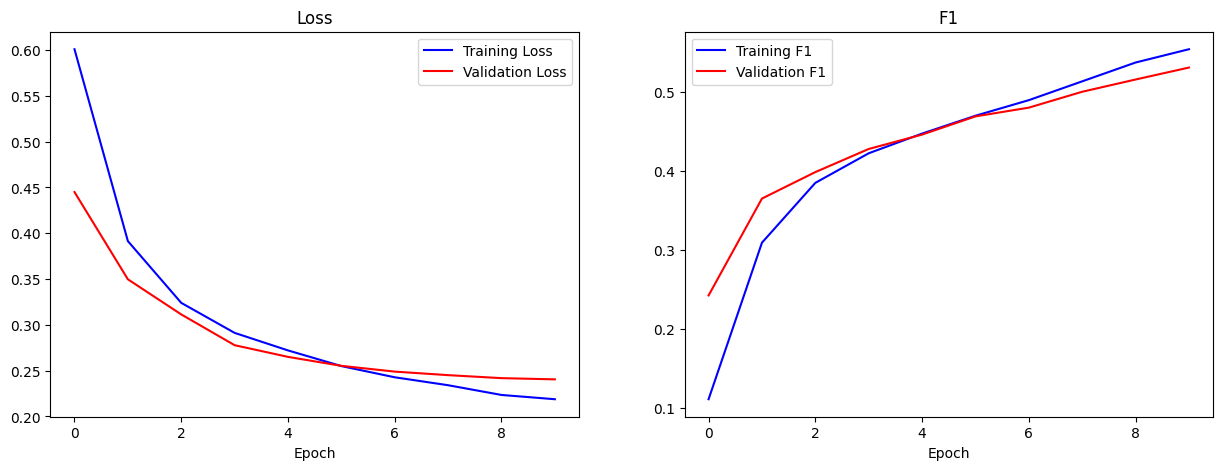

In [25]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [26]:
# fine_tune(lstm_fasttext_model, fasttext, val_data, criterion, optimizer, device='cuda', epochs=2)

In [28]:
lstm_fasttext_model = lstm_fasttext_model.to('cpu')
torch.save(lstm_fasttext_model, "t1_model2_fasttext.pt")

In [29]:
test_accuracy, test_f1 = test("t1_model2_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=False)
print(("LSTM with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.04955544125211257, 1: 0.05725971370143149, 2: 0.151033386327504, 3: 0.019407558733401428, 4: 0.04126048515075947, 5: 0.08282828282828283, 6: 0.07774294670846395, 7: 0.0816, 8: 0.1848314606741573, 9: 0.1315002988643156, 10: 0.17957124842370745, 11: 0.09421071556993887, 12: 0.07200929152148665, 13: 0.018433179723502304, 14: 0.05756405756405757, 15: 0.05960687454975815, 16: 0.3100401606425703, 17: 0.2380952380952381, 18: 0.06153846153846154, 19: 0.056410256410256404, 20: 0.04141414141414142, 21: 0.0, 22: 0.0, 23: 0.23298429319371727, 24: 0.04444444444444444, 25: 0.041666666666666664, 26: 0.032345013477088944}
Labelwise Accuracy Scores:
{0: 0.9823743627093955, 1: 0.34710743801652894, 2: 0.8284883720930233, 3: 0.11949685534591195, 4: 0.29354838709677417, 5: 0.5942028985507246, 6: 0.6358974358974359, 7: 0.6891891891891891, 8: 0.8590078328981723, 9: 0.8527131782945736, 10: 0.8146453089244852, 11: 0.7359550561797753, 12: 0.7607361963190185, 13: 0.06896551724137931, 1